<a href="https://colab.research.google.com/github/paudelsushil/labelcombinations/blob/main/Project_adleo_geog315_spring24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objective3:
# DeepLab3+ Model
DeepLabv3+ utilizes an encoder-decoder structure to perform image segmentation. The encoder extracts shallow and high-level semantic information from the image, while the decoder combines low-level and high-level features to improve the accuracy of segmentation boundaries and classify the semantic information of different pixels [Chen et al., (2018)](https://link.springer.com/content/pdf/10.1007/978-3-030-01234-2_49.pdf?pdf=inline%20link).

This project is based on the improved classis DeepLabv3+ network model proposed by [Chen et al.,(2023)](https://link.springer.com/content/pdf/10.1007/s40747-023-01304-z.pdf).

## Architecture of improved DeepLabv3+ with MobileNetv2 backbone

**`A. Encoder`**
 1. `Backbone` : lightweight network `MobileNetv2` in place of Xception.
 2. `ASPP` : `Hybrid Dialted Convolution` (HDC) module to alleviate the gridding effect. In addition,  `Strip Pooling Module` is used instead of spatial mean pooling to improve th elocal segmentation effect.
 3. `Normalization-based Attention Module` (NAM): This lightweight attention mechanism is also applied to the stacked compressed high-level feature maps to help improve the segmentation accuracy of the image.

**`B. Decoder`**
1. `NAM`: The seventh layer feature with `NAM` attention is upsampled to the same size as the fourth layer feature after fusion and channel adjustment.
2. `ResNet50`: This module is added to obtain riccher low-level target feature information.
3. `Concatenate`: The **deep features** and **shallow features** are concatenated as in the original model.
4. `Upsampling`: After a 3 X 3 convolution and 4 X `upsampling`, the image is restored to its original size.


 [Architecture Image]()

# 1. Mount the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


# 2. Install reqiured libraries

In [ ]:
%%capture
!pip install rasterio


# 3. Import necessary libraries

In [ ]:
# Import required packages
import os
from pathlib import Path

from datetime import datetime, timedelta
import tqdm # Adds a smart progress meter to any iterable or file operation

import math
import random
import pandas as pd
import numpy as np


import cv2
import rasterio
#  defines a rectangular area within the raster using four properties
# xoff, yoff, width, height
from rasterio.windows import Window


import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.tensorboard.writer import SummaryWriter


import logging
import pickle
from datetime import datetime
import itertools


from IPython.core.debugger import set_trace # Insert a breakpoint into the code
from IPython.display import Image

import matplotlib.pyplot as plt

# 4. Utility Functions


## 4.1 Error Handling Method

In [ ]:
class InputError(Exception):
    '''
    Exception raised for errors in the input
    '''
    def __init__(self, message):
        '''
        Params:
            message (str): explanation of the error
        '''
        self.message = message
    def __str__(self):
        '''
        Define message to return when error is raised
        '''
        if self.message:
            return 'InputError, {} '.format(self.message)
        else:
            return 'InputError'

## 4.2 Data Loading and Normalization

In [ ]:
# Data Loading
# =============================================================================
def load_data(data_path, usage="train", window=None, norm_stats_type=None,
              is_label=False):
    '''
    Read geographic data into numpy array
    Params:
        data_path : str
            Path of data to load
        usage : str
            Usage of the data: "train", "validate", or "predict"
        window : tuple
            The view onto a rectangular subset of the data, in the format of
            (column offsets, row offsets, width in pixel, height in pixel)
        norm_stats_type : str
            How the normalization statistics is calculated.
        is_label : binary
            Decide whether to saturate data with tested threshold
    Returns:
        narray
    '''

    with rasterio.open(data_path, "r") as src:

        if is_label:
            if src.count != 1:
                raise InputError("Label shape not applicable: \
                                 expected 1 channel")
            img = src.read(1)
        else:
            nodata = src.nodata
            assert norm_stats_type in ["local_per_tile", "local_per_band",
                                       "global_per_band"]
            if norm_stats_type == "local_per_tile":
                img = mmnorm1(src.read(), nodata=nodata)
            elif norm_stats_type == "local_per_band":
                img = mmnorm2(src.read(), nodata=nodata, clip_val=1.5)
            elif norm_stats_type == "global_per_band":
                img = mmnorm3(src.read(), nodata=nodata, clip_val=1.5)
            else:
                raise InputError("Invalid normalization type")

        if usage in ['train', 'validate'] and window is not None:
          img = img[:, max(0, window[1]): window[1] + window[3], \
                    max(0, window[0]): window[0] + window[2]]

    return img

# ==============================================================================
# Load and stack multiple geographic data (images) into numpy array
def get_stacked_img(img_paths, usage, norm_stats_type="local_per_tile",
                    window=None):
    '''
    Read geographic data into numpy array
    Params:
        gsPath :str
            Path of growing season image
        osPath : str
            Path of off season image
        img_paths : list
            List of paths for imgages
        usage : str
            Usage of the image: "train", "validate", or "predict"
        norm_stats_type : str
            How the normalization statistics is calculated.
        window : tuple
            The view onto a rectangular subset of the data, in the
            format of (column offsets, row offsets, width in pixel, height in
            pixel)
    Returns:
        ndarray
    '''

    if len(img_paths) > 1:  # If there are multiple image paths:
      img_ls = [load_data(m, usage, window, norm_stats_type) for m in img_paths]
      # Load data for each image path, potentially applying normalization
      img = np.concatenate(img_ls, axis=0).transpose(1, 2, 0)
      # Combine the loaded data into a single array and rearrange dimensions
    else:  # If there's only a single image path:
      # Load data for the single image path and rearrange dimensions
      img = load_data(img_paths[0], usage, \
                      window, norm_stats_type).transpose(1, 2, 0)

    # For 'train' or 'validate' subsets:
    if usage in ["train", "validate"] and window is not None:
      # Extract window parameters
      col_off, row_off, col_target, row_target = window
      row, col, c = img.shape  # Get image dimensions

      # Check if image is smaller than the target window
      if row < row_target or col < col_target:
          row_off = abs(row_off) if row_off < 0 else 0  # Adjust offsets
          col_off = abs(col_off) if col_off < 0 else 0

          # Create a larger blank canvas
          canvas = np.zeros((row_target, col_target, c))
          # Place image onto canvas
          canvas[row_off: row_off + row, col_off : col_off + col, :] = img
          return canvas  # Return the canvas with the padded image

      else:
          return img  # The image fits the window, so return it directly

    elif usage == "predict":  # For prediction purposes:
      return img  # Return the image as is

    else:
      raise ValueError  # Invalid 'usage' value
# ==============================================================================
# Methods to normalize image data using Min-Max values
def mmnorm1(img, nodata):
    '''
    Data normalization with min/max method
    Params:
        img (narray): The targeted image for normalization
    Returns:
        narrray
    '''

    img_tmp = np.where(img == nodata, np.nan, img)
    img_max = np.nanmax(img_tmp)
    img_min = np.nanmin(img_tmp)
    normalized = (img - img_min) / (img_max - img_min)
    normalized = np.clip(normalized, 0, 1)

    return normalized

# ------------------------------------------------------------------------------
# Methods to normalize image data using Min-Max values
def mmnorm2(img, nodata, clip_val=None):
    """
    Normalize the input image pixels to [0, 1] ranged based on the
    minimum and maximum statistics of each band per tile.
    Arguments:
            img : numpy array
                Stacked image bands with a dimension of (C,H,W).
            nodata : str
                Value reserved to represent NoData in the image chip.
            clip_val : int
                Defines how much of the distribution tails to be cut off.
    Returns:
            img : numpy array
                Normalized image stack of size (C,H,W).
    Note 1: If clip then min, max are calculated from the clipped image.
    """
    # filter out zero pixels in generating statistics.
    nan_corr_img = np.where(img == nodata, np.nan, img)
    nan_corr_img = np.where(img == 0, np.nan, img)
    if clip_val is not None and clip_val > 0:
        left_tail_clip = np.nanpercentile(nan_corr_img, clip_val)
        right_tail_clip = np.nanpercentile(nan_corr_img, 100 - clip_val)
        left_clipped_img = np.where(img < left_tail_clip, left_tail_clip, img)
        clipped_img = np.where(left_clipped_img > right_tail_clip,\
                               right_tail_clip, left_clipped_img)
        normalized_bands = []
        for i in range(img.shape[0]):
            band_min = np.nanmin(clipped_img[i, :, :])
            band_max = np.nanmax(clipped_img[i, :, :])
            normalized_band = (clipped_img[i, :, :] - band_min) / (band_max - band_min)
            normalized_bands.append(np.expand_dims(normalized_band, 0))
        normal_img = np.concatenate(normalized_bands, 0)
    elif clip_val == 0 or clip_val is None:
        normalized_bands = []
        for i in range(img.shape[0]):
            band_min = np.nanmin(nan_corr_img[i, :, :])
            band_max = np.nanmax(nan_corr_img[i, :, :])
            normalized_band = (nan_corr_img[i, :, :] - band_min) / (band_max - band_min)
            normalized_bands.append(np.expand_dims(normalized_band, 0))
        normal_img = np.concatenate(normalized_bands, 0)
    else:
        raise ValueError("clip must be a non-negative decimal.")
    normal_img = np.clip(normal_img, 0, 1)
    return normal_img

# ------------------------------------------------------------------------------
# Methods to normalize image data using pre-defined Min-Max values for each layer
def mmnorm3(img, nodata, clip_val=None):
    hardcoded_stats = {
        "mins": np.array([331.0, 581.0, 560.0, 1696.0]),
        "maxs": np.array([1403.0, 1638.0, 2076.0, 3652.0]) }
    num_bands = img.shape[0]
    mins = hardcoded_stats["mins"]
    maxs = hardcoded_stats["maxs"]
    if clip_val:
        normalized_bands = []
        for i in range(num_bands):
            nan_corr_img = np.where(img[i, :, :] == nodata, np.nan,
                                    img[i, :, :])
            nan_corr_img = np.where(img[i, :, :] == 0, np.nan, img[i, :, :])
            left_tail_clip = np.nanpercentile(nan_corr_img, clip_val)
            right_tail_clip = np.nanpercentile(nan_corr_img, 100 - clip_val)
            left_clipped_band = np.where(img[i, :, :] < left_tail_clip,
                                         left_tail_clip, img[i, :, :])
            clipped_band = np.where(left_clipped_band > right_tail_clip,
                                    right_tail_clip, left_clipped_band)
            normalized_band = (clipped_band - mins[i]) / (maxs[i] - mins[i])
            normalized_bands.append(np.expand_dims(normalized_band, 0))
        img = np.concatenate(normalized_bands, 0)
    else:
        for i in range(num_bands):
            img[i, :, :] = (img[i, :, :] - mins[i]) / (maxs[i] - mins[i])
    img = np.clip(img, 0, 1)
    return img
# ------------------------------------------------------------------------------
def min_max_normalize_image(image, dtype=np.float32):
    """
    image_path(str) : Absolute path to the image patch.
    dtype (numpy datatype) : data type of the normalized image default is
    "np.float32".
    """
    # Calculate the minimum and maximum values for each band
    min_values = np.nanmin(image, axis=(1, 2))[:, np.newaxis, np.newaxis]
    max_values = np.nanmax(image, axis=(1, 2))[:, np.newaxis, np.newaxis]
    # Normalize the image data to the range [0, 1]
    normalized_img = (image - min_values) / (max_values - min_values)
    # Return the normalized image data
    return normalized_img

## 4.3 Image Processing

In [ ]:
# Method to get buffered window to align and destination images
def get_buffered_window(src_path, dst_path, buffer):
    '''
    Get bounding box representing subset of source image that overlaps with
    bufferred destination image, in format of (column offsets, row offsets,
    width, height)
    Params:
        src_path : str
            Path of source image to get subset bounding box
        dst_path : str
            Path of destination image as a reference to define the
            bounding box. Size of the bounding box is
            (destination width + buffer * 2, destination height + buffer * 2)
        buffer :int
            Buffer distance of bounding box edges to destination image
            measured by pixel numbers
    Returns:
        tuple in form of (column offsets, row offsets, width, height)
    '''
    with rasterio.open(src_path, "r") as src:
        gt_src = src.transform

    with rasterio.open(dst_path, "r") as dst:
        gt_dst = dst.transform
        w_dst = dst.width
        h_dst = dst.height
    col_off = round((gt_dst[2] - gt_src[2]) / gt_src[0]) - buffer
    row_off = round((gt_dst[5] - gt_src[5]) / gt_src[4]) - buffer
    width = w_dst + buffer * 2
    height = h_dst + buffer * 2

    return col_off, row_off, width, height
# ------------------------------------------------------------------------------
# Method to get metadata of a specified image  while applying a buffer method
def get_meta_from_bounds(file, buffer):
    '''
    Get metadata of unbuffered region in given file
    Params:
        file (str):  File name of a image chip
        buffer (int): Buffer distance measured by pixel numbers
    Returns:
        dictionary
    '''
    with rasterio.open(file, "r") as src:
        meta = src.meta
        dst_width = src.width - 2 * buffer
        dst_height = src.height - 2 * buffer
        if buffer is not None:
          window = Window(buffer, buffer, dst_width, dst_height)

          win_transform = src.window_transform(window)
          meta.update({
            'width': dst_width,
            'height': dst_height,
            'transform': win_transform,
            'count': 1,
            'nodata': -128,
            'dtype': 'int8' })
        else:
          pass

    return meta
# ------------------------------------------------------------------------------
# Method to generate image chips from a large image data
def get_chips(img, dsize, buffer):
    '''
    Generate small chips from input images and the corresponding index of each
    chip The index marks the location of corresponding upper-left pixel of a
    chip.
    Params:
        img (narray): Image in format of (H,W,C) to be crop, in this case it is
            the concatenated image of growing season and off season
        dsize (int): Cropped chip size
        buffer (int):Number of overlapping pixels when extracting images chips
    Returns:
        list of cropped chips and corresponding coordinates
    '''
    h, w, _ = img.shape
    x_ls = range(0,h - 2 * buffer, dsize - 2 * buffer)
    y_ls = range(0, w - 2 * buffer, dsize - 2 * buffer)
    index = list(itertools.product(x_ls, y_ls))
    img_ls = []
    for i in range(len(index)):
        x, y = index[i]
        img_ls.append(img[x:x + dsize, y:y + dsize, :])

    return img_ls, index

## 4.4 Image data visualization

In [ ]:
# Method to vizualize a histogram of image data distribution
def display_hist(img):
    '''
    Display data distribution of input image in a histogram
    Params:
        img (narray): Image in form of (H,W,C) to display data distribution
    '''
    img = mmnorm1(img)
    im = np.where(img == 0, np.nan, img)
    plt.hist(img.ravel(), 500, [np.nanmin(im), img.max()])
    plt.figure(figsize=(20, 20))
    plt.show()
# ------------------------------------------------------------------------------
# Method to generate color composite based on the season
def comp432_dis(img, season):
    '''
    Generate false color composites
    Params:
        img (torch.tensor): Image in format of (C,H,W)
        season (str): Season of the composite to generate, be  "GS" or "OS"
    '''
    viewsize = img.shape[1:]
    if season == "GS":
        b4 = mmnorm1(img[3, :, :].cpu().view(1, *viewsize),0)
        b3 = mmnorm1(img[2, :, :].cpu().view(1, *viewsize),0)
        b2 = mmnorm1(img[1, :, :].cpu().view(1, *viewsize),0)
    elif season == "OS":
        b4 = mmnorm1(img[7, :, :].cpu().view(1, *viewsize), 0)
        b3 = mmnorm1(img[6, :, :].cpu().view(1, *viewsize), 0)
        b2 = mmnorm1(img[5, :, :].cpu().view(1, *viewsize), 0)
    else:
        raise ValueError("Bad season value")
    img = torch.cat([b4, b3, b2], 0)
    return img

# ------------------------------------------------------------------------------
# Method to visualize composites and labels
def display(img, label, mask):

    '''
    Display composites and their labels
    Params:
        img (torch.tensor): Image in format of (C,H,W)
        label (torch.tensor): Label in format of (H,W)
        mask (torch.tensor): Mask in format of (H,W)
    '''
    gsimg = (comp432_dis(img, "GS") * 255).permute(1, 2, 0).int()
    osimg = (comp432_dis(img, "OS") * 255).permute(1, 2, 0).int()

    _, figs = plt.subplots(1, 4, figsize=(20, 20))

    label = label.cpu()

    figs[0].imshow(gsimg)
    figs[1].imshow(osimg)
    figs[2].imshow(label)
    figs[3].imshow(mask)

    plt.show()

## 4.5 Reproducibile, progress report, and Logs

In [ ]:
# Method to make all the randomization processes start from a shared seed.
def make_reproducible(seed=42, cudnn=True):
    """Make all the randomization processes start from a shared seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.random.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if cudnn:
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
# ------------------------------------------------------------------------------
def progress_reporter(msg, verbose, logger=None):
    """Helps control print statements and log writes
    Parameters
    ----------
    msg : str
      Message to write out
    verbose : bool
      Prints or not to console
    logger : logging.logger
      logger (defaults to none)
    Returns:
    --------
        Message to console and or log
    """
    if verbose:
        print(msg)
    if logger:
        logger.info(msg)

# ------------------------------------------------------------------------------
# Method to create a logger
def setup_logger(log_dir, log_name, use_date=False):
    """Create logger
    """
    if use_date:
        dt = datetime.now().strftime("%d%m%Y_%H%M")
        log = "{}/{}_{}.log".format(log_dir, log_name, dt)
    else:
        log = "{}/{}.log".format(log_dir, log_name)

    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    log_format = (
        f"%(asctime)s::%(levelname)s::%(name)s::%(filename)s::"
        f"%(lineno)d::%(message)s"
    )
    logging.basicConfig(filename=log, filemode='w',
                        level=logging.INFO, format=log_format)

    return logging.getLogger()


## 4.6 Pickle Serialization

In [ ]:
# Method to save a dataset object as a serialized file
def pickle_dataset(dataset, file_path):
    with open(file_path, "wb") as fp:
        pickle.dump(dataset, fp)

# Method to load a dataset object from a serialized file
def load_pickle(file_path):
    return pd.read_pickle(file_path)

# 5. Data Preparation
1. Find the suitable `image dataset` to apply `improved DeepLabv3+ model` for the image segmentation process.
  - For this task, we used image dataset that was used in `S. Khallaghi, (2024) ch. 2`.
2. Prepare the `labels (pixel-wise annotations)` that are compatible with selected image dataset.
  - For this task, we filtered [all_class_cataloge](/content/gdrive/MyDrive/adleo/project_data/label_catalog_allclasses.csv) using methods and functions given in [notebook](https://github.com/paudelsushil/labelcombinations/blob/main/Make_Labels_ADLEO_Final.ipynb) and prepared final [filtered cataloge](/content/gdrive/MyDrive/adleo/project_data/label-catalog-filtered.csv) to get our pixel-wise annotations as a [lable images](/content/gdrive/MyDrive/adleo/project_data/labels).


## 5.1 Check for GPU availability

In [ ]:
# 5.1 Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


##5.2 Image Augmentation



In [ ]:
# Method to Applies horizontal or vertical flip augmentation
# to an image patch and label
def flip_image_and_label(image, label, flip_type):
    """
    Applies horizontal or vertical flip augmentation to an image patch and label

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        flip_type (string) : Based on the direction of flip. Can be either
            'hflip' or 'vflip'.
    Returns:
        A tuple containing the flipped image patch and label as numpy arrays.
    """
    if flip_type == 'hflip':
        # Apply horizontal flip augmentation to the image patch
        flipped_image = cv2.flip(image, 1)
        # Apply horizontal flip augmentation to the label
        flipped_label = cv2.flip(label, 1)
    elif flip_type == 'vflip':
        # Apply vertical flip augmentation to the image patch
        flipped_image = cv2.flip(image, 0)
        # Apply vertical flip augmentation to the label
        flipped_label = cv2.flip(label, 0)
    else:
        raise ValueError("Flip direction must be 'horizontal' or 'vertical'.")
    # Return the flipped image patch and label as a tuple
    return flipped_image.copy(), flipped_label.copy()

# ------------------------------------------------------------------------------
# Method  to apply rotation augmentation to an image patch and label.
def rotate_image_and_label(image, label, angle):
    """
    Applies rotation augmentation to an image patch and label.
    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        angle (lost of floats) : If the list has exactly two elements they will
            be considered the lower and upper bounds for the rotation angle
            (in degrees) respectively. If number of elements are bigger than 2,
            then one value is chosen randomly as the roatation angle.
    Returns:
        A tuple containing the rotated image patch and label as numpy arrays.
    """
    if isinstance(angle, tuple) or isinstance(angle, list):
        if len(angle) == 2:
            rotation_degree = random.uniform(angle[0], angle[1])
        elif len(angle) > 2:
            rotation_degree = random.choice(angle)
        else:
            raise ValueError("Parameter degree needs at least two elements.")
    else:
        raise ValueError(
            "Rotation bound param for augmentation must be a tuple or list."
        )
    # Define the center of the image patch
    center = tuple(np.array(label.shape)/2.0)
    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_degree, 1.0)
    # Apply rotation augmentation to the image patch
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2],
                                   flags=cv2.INTER_LINEAR)
    # Apply rotation augmentation to the label
    rotated_label = cv2.warpAffine(label, rotation_matrix, label.shape[:2],
                                   flags=cv2.INTER_NEAREST)
    # Return the rotated image patch and label as a tuple
    return rotated_image.copy(), np.rint(rotated_label.copy())

## 5.3 Image patch generator

In [ ]:
# Method to generate index to divide the scene into small chips
def patch_center_index(cropping_ref, patch_size, overlap, usage,
                       positive_class_threshold=None, verbose=True):
    """
    Generate index to divide the scene into small chips.
    Each index marks the location of corresponding chip center.
    Arguments:
        cropping_ref (list) : Reference raster layers, to be used to generate
            the index. In our case, it is study area binary mask and label mask.
        patch_size (int) : Size of each clipped patches.
        overlap (int) : amount of overlap between the extracted chips.
        usage (str) : Either 'train', 'val'. Chipping strategy is different for
            different usage.
        positive_class_threshold (float) : A real value as a threshold for the
            proportion of positive class to the total areal of the chip. Used to
            decide if the chip should be considered as a positive chip in the
            sampling process.
    verbose (binary) : If set to True prints on screen the detailed list of
            center coordinates of the sampled chips.
    Returns:
        proportional_patch_index : A list of index recording the center of
        patches to extract from the input
    """
    assert usage in ["train", "validation", "inference"]

    if usage == "inference":
        mask = cropping_ref
    else:
        mask, label = cropping_ref

    half_size = patch_size // 2
    step_size = patch_size - 2 * overlap

    proportional_patch_index = []
    non_proportional_patch_index = []
    neg_patch_index = []
    # Get the index of all the non-zero elements in the mask.
    x = np.argwhere(mask)
    # First col of x shows the row indices (height) of the mask layer
    # (iterate over the y axis or latitude).
    x_min = min(x[:, 0]) + half_size
    x_max = max(x[:, 0]) - half_size
    # Second col of x shows the column indices (width) of the mask layer
    # (iterate over the x axis or longitude).
    y_min = min(x[:, 1]) + half_size
    y_max = max(x[:, 1]) - half_size
    # Generate index for the center of each patch considering the proportion of
    # each category falling into each patch.
    for j in range(y_min, y_max + 1, step_size):

        for i in range(x_min, x_max + 1, step_size):
            # Split the mask and label layers into patches based on the index of
            # the center of the patch
            mask_ref = mask[i - half_size: i + half_size,
                            j - half_size: j + half_size]
            if usage != "inference":
                label_ref = label[i - half_size: i + half_size,
                                  j - half_size: j + half_size]

            if (usage == "train") and mask_ref.all():

                if label_ref.any() != 0:
                    pond_ratio = np.sum(label_ref == 1) / label_ref.size
                    if pond_ratio >= positive_class_threshold:
                        proportional_patch_index.append([i, j])
                else:
                    neg_patch_index.append([i, j])

            if (usage == "validation") and (label_ref.any() != 0) \
                and mask_ref.all():
                non_proportional_patch_index.append([i, j])

            if (usage == "inference") and (mask_ref.any() != 0):
                non_proportional_patch_index.append([i, j])

    if usage == "train":

        num_negative_samples = min(
            math.ceil(0.2 * len(proportional_patch_index)), 15
        )
        neg_samples = random.sample(neg_patch_index, num_negative_samples)

        proportional_patch_index.extend(neg_samples)

    # For test set use the indices generated from mask without
    # considering the class proportions.
    if usage in ["validation", "inference"]:
        proportional_patch_index = non_proportional_patch_index

    if verbose:
        print("Number of patches:", len(proportional_patch_index))
        print("Patched from:\n{}".format(proportional_patch_index))

    return proportional_patch_index

## 5.4 Active dataset loading method


In [ ]:
class datasetloader(Dataset):
    def __init__(self, src_dir, usage, dataset_name=None,
                 transform=None, norm_stats_type="local_per_tile",
                 patch_size=None, overlap=None, catalog_index=None,
                 buffer=None):
        """
        src_dir (str or path): Root of resource directory.
        dataset_name (str): Name of the training/validation dataset containing
                              structured folders for image, label
        usage (str): Either 'train' or 'validation'.
        transform (list): Each element is string name of the transformation to
            be used.
        """
        # Initialize dataset parameters
        self.src_dir = src_dir
        self.dataset_name = dataset_name
        self.transform = transform
        self.norm_stats_type = norm_stats_type
        self.patch_size = patch_size
        self.overlap = overlap
        self.usage = usage

        # Ensure that the usage is one of the expected options
        assert self.usage in ["train", "validation", "inference"], "Usage is not recognized."

        if self.usage in ["train", "validation"]:
            # For training or validation, set up image and label directories
            assert self.dataset_name is not None
            img_dir = Path(src_dir) / self.dataset_name / self.usage / "bands"
            img_fnames = [
                Path(dirpath) / f
                for dirpath, _, filenames in os.walk(img_dir)
                for f in filenames if f.endswith(".tif")
            ]
            img_fnames.sort()

            lbl_dir = Path(src_dir) / self.dataset_name / self.usage / "labels"
            lbl_fnames = [
                Path(dirpath) / f
                for dirpath, _, filenames in os.walk(lbl_dir)
                for f in filenames if f.endswith(".tif")
            ]
            lbl_fnames.sort()

            # Load all image and label chips
            self.img_chips = []
            self.lbl_chips = []

            for img_path, lbl_path in tqdm.tqdm(zip(img_fnames, lbl_fnames),
                                                total=len(img_fnames)):
                # Load and normalize image chips based on the provided normalization stats
                img_chip = load_data(img_path, usage=self.usage, \
                norm_stats_type=self.norm_stats_type, is_label=False)
                img_chip = img_chip.transpose((1, 2, 0))

                # Load label chips
                lbl_chip = load_data(lbl_path, usage=self.usage, is_label=True)

                # Append to the lists
                self.img_chips.append(img_chip)
                self.lbl_chips.append(lbl_chip)

            print(f"Loaded {len(self.img_chips)} image chips")
            print(f"Loaded {len(self.lbl_chips)} label chips")

        else:
            # For inference, read the catalog for metadata
            assert self.csv_name is not None

            # Load the catalog and select the relevant row
            catalog = pd.read_csv(os.path.join(self.src_dir, self.csv_name))
            self.catalog = catalog.iloc[catalog_index]

            # Extract image and mask paths from the catalog
            self.tile = (self.catalog["wrs_path"], self.catalog["wrs_row"])
            img_path_ls = [self.catalog["img_dir"]]
            mask_path_ls = [self.catalog["mask_dir"]]

            # Get metadata for the selected image
            self.meta = get_meta_from_bounds(Path(src_dir) / img_path_ls[0], buffer = None)

            # Define the half size of patches for indexing
            half_size = self.patch_size // 2

            self.img_chips = []
            self.coor = []

            for img_path, mask_path in zip(img_path_ls, mask_path_ls):
                # Load and normalize image chips
                img = load_data(os.path.join(self.src_dir, img_path), \
                usage=self.usage, norm_stats_type=self.norm_stats_type, \
                                is_label=False)
                img = np.transpose(img, (1, 2, 0))

                # Load the mask data for indexing
                mask = load_data(os.path.join(self.src_dir, mask_path), \
                                 usage=self.usage, is_label=True)

                # Generate indices based on the mask and patch size
                index = patch_center_index(mask, self.patch_size, self.overlap, self.usage)

                for i in range(len(index)):
                    x = index[i][0]
                    y = index[i][1]

                    # Extract and store each image patch based on the indices
                    self.img_chips.append(img[x - half_size: x + half_size, y - half_size: y + half_size, :])
                    self.coor.append([x, y])

            print(f"Loaded {len(self.img_chips)} image patches")

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.img_chips)

    def __getitem__(self, index):
        """Return the sample at the given index, ensuring it's valid."""
        if self.usage in ["train", "validation"]:
            image_chip = self.img_chips[index]
            label_chip = self.lbl_chips[index]

            # Check if the chips are valid
            if image_chip is None or image_chip.size == 0 or label_chip is None or label_chip.size == 0:
                return None

            if self.usage == "train" and self.transform:
                # Apply transformations if applicable
                trans_flip_ls = [m for m in self.transform if "flip" in m]
                if random.randint(0, 1) and len(trans_flip_ls) > 1:
                    trans_flip = random.sample(trans_flip_ls, 1)[0]
                    image_chip, label_chip = flip_image_and_label(image_chip, label_chip, trans_flip)

                if random.randint(0, 1) and "rotate" in self.transform:
                    image_chip, label_chip = rotate_image_and_label(image_chip, label_chip, angle=[0, 90])

            # Convert numpy arrays to torch tensors
            image_tensor = torch.from_numpy(image_chip.transpose((2, 0, 1))).float()
            label_tensor = torch.from_numpy(np.ascontiguousarray(label_chip)).long()

            return image_tensor, label_tensor
        else:
            # For inference, return image chips and coordinates
            coor = self.coor[index]
            img_chip = self.img_chips[index]

            if img_chip is None or img_chip.size == 0:
                return None

            image_tensor = torch.from_numpy(img_chip.transpose((2, 0, 1))).float()
            return image_tensor, coor


## 5.5 Collate method for dataloader

In [ ]:
# Collate method for dataloader to handle "None" batches
def collate(batch):
  """
  Collate function for dataloader.
  """
  batch = list(filter(lambda x: x is not None, batch))
  return torch.utils.data.dataloader.default_collate(batch)

# 6. Model Building


## 6.1 Basic Convolutional Neural blocks

In [ ]:
class Conv1x1_bn_relu(nn.Module):
    def __init__(self, inch, outch, stride = 1, padding = 0, dilation = 1,\
                 groups = 1, relu = True):
        super(Conv1x1_bn_relu, self).__init__()
        self.applyRelu = relu
        self.conv = nn.Sequential(nn.Conv2d(inch, outch, 1, stride = stride,\
                                            padding = padding, \
                                            dilation = dilation,
                                            groups = groups),
                                  nn.BatchNorm2d(outch))

        if self.applyRelu:
            self.relu = nn.ReLU(True)
    def forward(self, x):
        x = self.conv(x.clone())
        if self.applyRelu:
            x = self.relu(x)
        return x

# ------------------------------------------------------------------------------
class Conv3x3_bn_relu(nn.Module):
    def __init__(self, inch, outch, padding = 0, stride =1, dilation = 1, \
                 groups = 1, relu = True):
        super(Conv3x3_bn_relu, self).__init__()
        self.applyRelu = relu

        self.conv = nn.Sequential(nn.Conv2d(inch, outch, 3, \
                                            padding = padding, stride = stride,\
                                            dilation = dilation,
                                            groups = groups),
                                  nn.BatchNorm2d(outch))
        if self.applyRelu:
            self.relu = nn.ReLU(True)

    def forward(self, x):
        out = self.conv(x)
        if self.applyRelu:
            out = self.relu(out)
        return out

## 6.2 Model Backbone
ResNet101

In [ ]:
block_num = {"resnet101": [3, 4, 23, 3]}
dilations_by_outStride = {
    16: [1, 1, 1, 2],
    8: [1, 1, 2,4]
}
class Resnet(nn.Module):
    def __init__(self, block, inch, outStride, layers, firstKernel=7, firstStride=2, firstPadding=3):
        super(Resnet, self).__init__()

        dilations = dilations_by_outStride[outStride]

        self.conv1 = nn.Sequential(nn.Conv2d(inch, 64, firstKernel, stride=firstStride, padding=firstPadding), \
                                   nn.BatchNorm2d(64), \
                                   nn.ReLU(True)) # 1/2

        # # 7x7 conv to three 3x3 conv
        # layer0 = []
        # for i in range(ceil(firstKernel/3.0)):
        #     if i == 0:
        #         layer0.append(Conv3x3_bn_relu(inch, 64, padding = 1, stride = firstStride))
        #     else:
        #         layer0.append(Conv3x3_bn_relu(64, 64, padding = 1))
        # self.conv1 = nn.Sequential(*layer0)

        self.pool1 = nn.MaxPool2d(2, stride=2, padding=0) # original
        # self.pool1 = nn.MaxPool2d(2, stride=2, padding=0)

        self.stage1 = self.makeStage(block, 64, 1, layers[0], dilation = dilations[0], firstStage=True, ) # 1/4
        self.stage2 = self.makeStage(block, 128, 2, layers[1], dilation = dilations[1])  # 1/8
        self.stage3 = self.makeStage(block, 256, 2, layers[2], dilation = dilations[2])  # 1/16
        self.stage4 = self.makeStage(block, 512, 1, layers[3], dilation = dilations[3]) # 1/16

        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         nn.init.kaiming_normal_(m.weight, mode = "fan_out", nonlinearity = "relu")
        # m.bias.data.fill_(0)

    def makeStage(self, block, transch, firstStride, blocks, dilation, firstStage=False):
        layers = []

        # expansion = 1/4 for basicblock/bottleneck
        outch = int(transch * block.expansion) # 64*4=256

        if firstStage:
            inch = transch  # 64
        else:
            inch = int(transch * block.expansion / 2)

        # dilation setting
        # if dilation is None:
        #     dilations = [1]*blocks
        # else:
        #     if len(dilation) != blocks:
        #         raise ValueError('Expect dilations to have length {}'.format(blocks))

        for i in range(blocks):
            if i == 0:
                conv = block(inch, outch, dilation = dilation, firstStride=firstStride)
            else:
                conv = block(outch, outch, dilation = dilation)
            layers.append(conv)

        return (nn.Sequential(*layers))

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x0 = self.stage1(x) # 128
        x = self.stage2(x0) # 64
        x = self.stage3(x) #32
        x = self.stage4(x)

        return x0, x


# ------------------------------------------------------------------------------


class bottleNeck(nn.Module):
    expansion = 4
    def __init__(self, inch, outch, dilation = 1, firstStride = 1, groups = 1, \
                 base_width = 64):
        super(bottleNeck, self).__init__()

        self.firstBlock = (inch != outch)
        transch = int(outch / (self.expansion * groups * base_width / 64))

        # downsample in first 1x1 convolution
        if self.firstBlock:
            self.conv0 = Conv1x1_bn_relu(inch, outch, stride=firstStride, \
                                         relu=False)

        # 1x1 conv
        self.conv1 = Conv1x1_bn_relu(inch, transch, stride=firstStride)
        # 3x3 conv
        self.conv2 = Conv3x3_bn_relu(transch, transch, padding = dilation,\
                                     dilation = dilation, groups = groups)
        # 1x1 conv
        self.conv3 = Conv1x1_bn_relu(transch, outch, relu=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        res = self.conv1(x)
        res = self.conv2(res)
        res = self.conv3(res)

        if self.firstBlock:
            x = self.conv0(x)

        out = self.relu(res + x)
        return out
# ------------------------------------------------------------------------------
class resnet101(nn.Module):
    def __init__(self, inch, outStride):
        super(resnet101, self).__init__()
        self.resnet = Resnet(bottleNeck, inch, outStride, layers=block_num["resnet101"])

    def forward(self, x):
        x = self.resnet(x)
        return x

## 6.3 Model **ASSP**

In [ ]:
class ASPP(nn.Module):
    def __init__(self, inch, rates, stagech):
        super(ASPP, self).__init__()
        '''
        This class generates the ASPP module introduced in
        DeepLabv3: https://arxiv.org/pdf/1706.05587.pdf, which
         concatenates 4 parallel atrous spatial pyramid pooling and the image
         level features. For more detailed information, please refer to the
         paper of DeepLabv3

         Args:
            inch -- (int) Depth of the input tensor
            rates -- (list) A list of rates of the parallel atrous convolution,
                     including that for the 1x1 convolution
            stagech -- (int) Depth of output tensor for each of the parallel
                    atrous convolution

         Returns:
            A tensor after a 1x1 convolution of the concatenated ASPP features
        '''
        super(ASPP, self).__init__()
        # create stages
        self.rates = rates
        self.inch = inch
        self.stagech = stagech

        self.stages = self.makeStages()
        # global feature
        self.globe = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)), \
                                   Conv1x1_bn_relu(inch, stagech, relu = False))
        # self.conv1x1 = Conv1x1_bn_relu(inch, stagech, relu = False)
        # self.conv = Conv3x3_bn_relu(inch * 2, inch, padding = 1)
        self.conv = Conv1x1_bn_relu(stagech*(len(rates) + 1), stagech,\
                                    relu = False)

    def makeStages(self):
        outch = self.stagech
        inch = self.inch
        stages = []
        for rate in self.rates:
            if rate == 1:
                stage = Conv1x1_bn_relu(inch, outch, relu = False)

            else:
                stage = Conv3x3_bn_relu(inch, outch, padding =rate,\
                                        dilation = rate, relu = False)
            stages.append(stage)
        return nn.ModuleList(stages)

    def forward(self, x):
        x_size = x.size()
        # x1 = [F.interpolate(stage(x), size=x_size[-2:], mode="bilinear",
        #  align_corners=True) for stage in self.stages]
        x0 = [stage(x) for stage in self.stages]

        # global feature
        x1 = self.globe(x)
        x1 = F.interpolate(x1, size = x_size[-2:], mode = "bilinear",\
                           align_corners = True)

        x = torch.cat(x0 + [x1], 1)
        x = self.conv(x)

        return x


## 6.4 DeepLabv3plus
DeepLabV3+ using ResNet101 as a model backbone

In [ ]:
ASPPInchByBackbone = {"resnet": 2048}
quaterOutchByBackbone = {"resnet": 256}

class deeplab3plus2(nn.Module):
    def __init__(self, inch, classNum, backbone = resnet101, outStride = 16,
                 rates = [1, 6, 12, 18]):
        super(deeplab3plus2, self).__init__()

        # backbone
        self.backbone = backbone(inch, outStride = outStride)

        # ASPP
        ASPPinch = ASPPInchByBackbone[backbone.__name__.rstrip('0123456789')]
        ASPPoutch = ASPPinch // 8
        self.ASPP = ASPP(ASPPinch, rates=rates, stagech=ASPPoutch)

        # decoder
        quaterOutch = quaterOutchByBackbone[backbone.__name__.rstrip('0123456789')]
        self.conv0 = Conv1x1_bn_relu(quaterOutch, ASPPoutch) # 1/4 of origin
        self.up1 = nn.ConvTranspose2d(256, 256, 6, stride=4, padding=1)
        self.last_conv = nn.Sequential(Conv3x3_bn_relu(ASPPoutch*2, 256, 1),
                                       Conv3x3_bn_relu(256, 256, 1),
                                       nn.Conv2d(256, classNum, 1))
        self.up2 = nn.ConvTranspose2d(classNum, classNum, 6, stride=4, padding=1)


    def forward(self, x):

        x0, x = self.backbone(x)
        x = self.ASPP(x)

        # decoder
        x0 = self.conv0(x0)
        x = self.up1(x)
        x = torch.cat([x, x0], 1)
        x = self.last_conv(x)
        x = self.up2(x)

        return x

# 7 Model Training and Evaluation
## 7.1 Hyperparameter and Dataset Initialization

In [ ]:
# Define the hyperparameters
batch_size = 16
num_epochs = 5
initial_lr = 0.001
num_classes = 2
data_dir = "/content/gdrive/MyDrive/adleo/assignment5/A5_resources"
WorkingFolder = "/content/gdrive/MyDrive/adleo/adleo_project_test"


# ------------------------------------------------------------------------------
# Create the training and validation datasets using the `datasetloader`
# class with appropriate parameters
train_dataset = datasetloader(
    src_dir=data_dir,
    usage="train",
    dataset_name="Global",
    transform=["hflip", "vflip", "rotate"],
    patch_size=256,
    overlap=64
)

val_dataset = datasetloader(
    src_dir=data_dir,
    usage="validation",
    dataset_name="Global",
    patch_size=256,
    overlap=64
)

# Load datasets using DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 1188/1188 [09:54<00:00,  2.00it/s]


Loaded 1188 image chips
Loaded 1188 label chips


100%|██████████| 239/239 [01:56<00:00,  2.05it/s]

Loaded 239 image chips
Loaded 239 label chips


## 7.2 Model Initialization and Configuration

In [ ]:
# Initialize the ResUNet model
model = deeplab3plus2(inch=6,  classNum=num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

# Determine device availability (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

deeplab3plus2(
  (backbone): resnet101(
    (resnet): Resnet(
      (conv1): Sequential(
        (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (stage1): Sequential(
        (0): bottleNeck(
          (conv0): Conv1x1_bn_relu(
            (conv): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
              (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
          (conv1): Conv1x1_bn_relu(
            (conv): Sequential(
              (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (relu): ReLU(inplace=True)
    

## 7.3 Methods for Training and Validation

In [ ]:
# Method to train the model
# Function to train the model
def train(train_loader, model, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Function to validate the model
def validate(val_loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(val_loader)

## 7.4 Method for Epoch Iterator

In [ ]:
def epochIterater(trainData, valData, model, criterion, WorkingFolder,
                  initial_lr, num_epochs):
    """
    Epoch iteration for train and evaluation.

    Arguments:
    trainData (dataloader object): Batch grouped data to train the model.
    evalData (dataloader object): Batch grouped data to evaluate the model.
    model (pytorch.nn.module object): initialized model.
    initial_lr(float): The initial learning rate.
    num_epochs (int): User-defined number of epochs to run the model.

    """

    train_loss = []
    val_loss = []

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if device.type == "cuda":
        print('----------GPU available----------')
        model = model.to(device)
    else:
        print('----------No GPU available, using CPU instead----------')
        model = model

    writer = SummaryWriter(WorkingFolder)
    optimizer = optim.Adam(model.parameters(),
                           lr=initial_lr,
                           betas=(0.9, 0.999),
                           eps=1e-08,
                           weight_decay=5e-4,
                           amsgrad=False)

    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=3,
                                          gamma=0.90)
    start_epoch = datetime.now()
    for t in range(num_epochs):
        print("Epoch [{}/{}]".format(t + 1, num_epochs))

        train(trainData, model, optimizer, criterion, device,
              train_loss=train_loss)
        validate(valData, model, criterion, device, val_loss=val_loss)

        scheduler.step()
        print("LR: {}".format(scheduler.get_last_lr()))

        writer.add_scalars("Loss",
                           {"train loss": train_loss[t],
                            "validation loss": val_loss[t]},
                           t + 1)

    writer.close()

    duration_epoch = datetime.now() - start_epoch
    duration_format = str(timedelta(seconds=duration_epoch.seconds))
    print("--------------- Training finished in {} ---------------"\
          .format(duration_format))

## 7.5 Evaluator Class

In [ ]:
class Evaluator:
    """Evaluator class for computing accuracy and IoU metrics on a segmentation model."""

    def __init__(self, num_class):
        """Initialize the evaluator with the specified number of classes.

        Args:
            num_class (int): Number of classes for the segmentation task.
        """
        self.num_class = num_class
        # Initialize a confusion matrix for tracking class-wise predictions
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

    def Pixel_Accuracy(self):
        """Compute the overall pixel accuracy.

        Returns:
            float: The proportion of correctly classified pixels.
        """
        Acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return Acc

    def Pixel_Accuracy_Class(self):
        """Compute the pixel accuracy per class.

        Returns:
            float: The mean pixel accuracy across all classes.
        """
        Acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
        Acc = np.nanmean(Acc)
        return Acc

    def Mean_Intersection_over_Union(self):
        """Compute the mean Intersection over Union (IoU) across all classes.

        Returns:
            float: The mean IoU value.
        """
        MIoU = np.diag(self.confusion_matrix) / (
            np.sum(self.confusion_matrix, axis=1) +
            np.sum(self.confusion_matrix, axis=0) -
            np.diag(self.confusion_matrix))
        MIoU = np.nanmean(MIoU)
        return MIoU

    def Frequency_Weighted_Intersection_over_Union(self):
        """Compute the frequency-weighted IoU metric.

        Returns:
            float: The frequency-weighted IoU value.
        """
        freq = np.sum(self.confusion_matrix, axis=1) / np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
            np.sum(self.confusion_matrix, axis=1) +
            np.sum(self.confusion_matrix, axis=0) -
            np.diag(self.confusion_matrix))

        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU

    def _generate_matrix(self, gt_image, pre_image):
        """Generate a confusion matrix given the ground truth and predicted images.

        Args:
            gt_image (np.array): Ground truth labels.
            pre_image (np.array): Predicted labels.

        Returns:
            np.array: A confusion matrix.
        """
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def add_batch(self, gt_image, pre_image):
        """Accumulate confusion matrix values from a batch of predictions.

        Args:
            gt_image (np.array): Ground truth labels.
            pre_image (np.array): Predicted labels.
        """
        assert gt_image.shape == pre_image.shape
        self.confusion_matrix += self._generate_matrix(gt_image, pre_image)

    def reset(self):
        """Reset the confusion matrix to zero."""
        self.confusion_matrix = np.zeros((self.num_class,) * 2)


## 7.6 Method for model Evaluation

In [ ]:
def do_accuracy_evaluation(model, dataloader, num_classes):
    """Evaluate the segmentation model on the given dataset.

    Args:
        model (torch.nn.Module): The segmentation model.
        dataloader (torch.utils.data.DataLoader): Dataloader for the evaluation dataset.
        num_classes (int): Number of segmentation classes.

    Returns:
        tuple: Pixel accuracy, mean accuracy, mean IoU, and frequency-weighted IoU.
    """
    evaluator = Evaluator(num_classes)

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            evaluator.add_batch(labels.cpu().numpy(), preds.cpu().numpy())

    pixel_accuracy = evaluator.Pixel_Accuracy()
    mean_accuracy = evaluator.Pixel_Accuracy_Class()
    mean_IoU = evaluator.Mean_Intersection_over_Union()
    frequency_weighted_IoU = evaluator.Frequency_Weighted_Intersection_over_Union()

    return pixel_accuracy, mean_accuracy, mean_IoU, frequency_weighted_IoU

## Applying the epochIterator

In [ ]:
# Training loop
train_loss = []
val_loss = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_epoch_loss = train(train_loader, model, optimizer, criterion, device)
    val_epoch_loss = validate(val_loader, model, criterion, device)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    scheduler.step()
    print(f"Training Loss: {train_epoch_loss:.4f} | Validation Loss: {val_epoch_loss:.4f}")

### Load evaluation method for model evaluation.

In [ ]:
# Evaluate the model's accuracy
pixel_accuracy, mean_accuracy, mean_IoU, frequency_weighted_IoU = do_accuracy_evaluation(model, val_loader, num_classes)

# Display the evaluation metrics results
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean IoU: {mean_IoU:.4f}")
print(f"Frequency Weighted IoU: {frequency_weighted_IoU:.4f}")

Pixel Accuracy: 0.8839
Mean Accuracy: 0.9057
Mean IoU: 0.7803
Frequency Weighted IoU: 0.7982


# 8. Results

##8.1 Method to plot prediction

In [ ]:
# Function to visualize predictions
def plot_predictions(model, data_loader, device, num_images=5):
    """Visualize predictions from the model compared to ground truth labels.

    Parameters:
        model (torch.nn.Module): Trained model for segmentation.
        data_loader (torch.utils.data.DataLoader): DataLoader for the dataset.
        device (torch.device): Device onde o modelo está rodando.
        num_images (int): Número de imagens para visualizar.
    """
    model.eval()
    images_displayed = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Move data back to CPU for visualization
            images = images.cpu()
            labels = labels.cpu()
            preds = preds.cpu()

            # Visualize predictions compared to ground truth
            for i in range(min(num_images, len(images))):
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))

                # Select only three channels for display or compute mean
                image_display = images[i, :3].permute(1, 2, 0)  # Consider only the first 3 channels

                axs[0].imshow(image_display)
                axs[0].set_title("Input Image")
                axs[1].imshow(labels[i], cmap="gray")
                axs[1].set_title("Ground Truth")
                axs[2].imshow(preds[i], cmap="gray")
                axs[2].set_title("Prediction")
                plt.show()

                images_displayed += 1
                if images_displayed >= num_images:
                    return



### Plot predictions

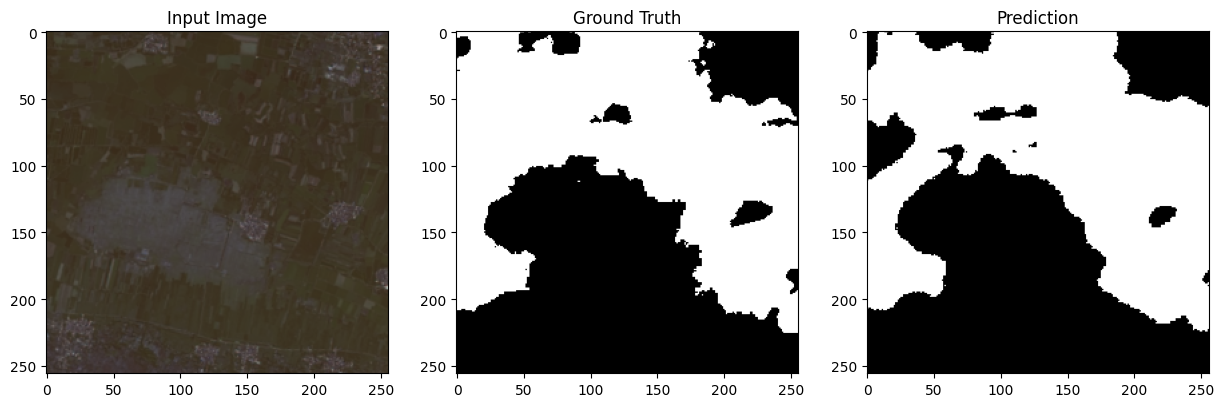

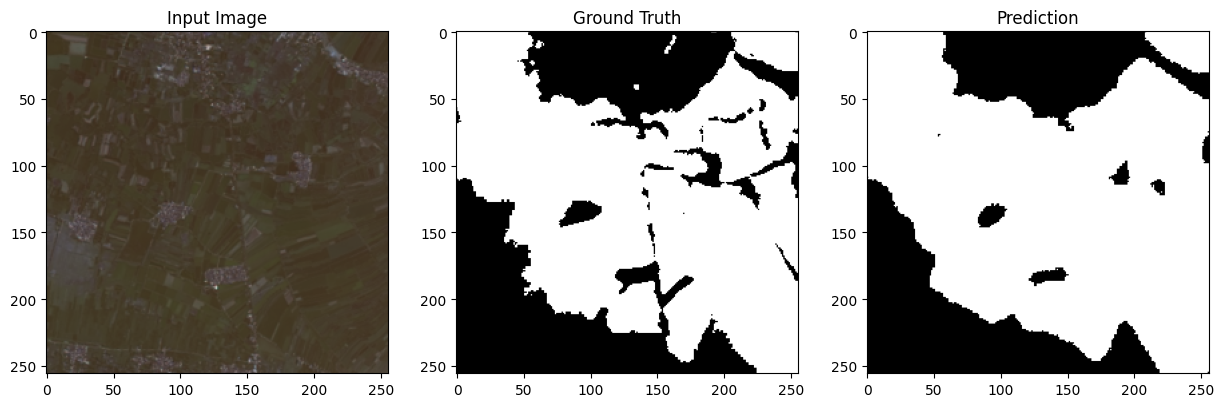

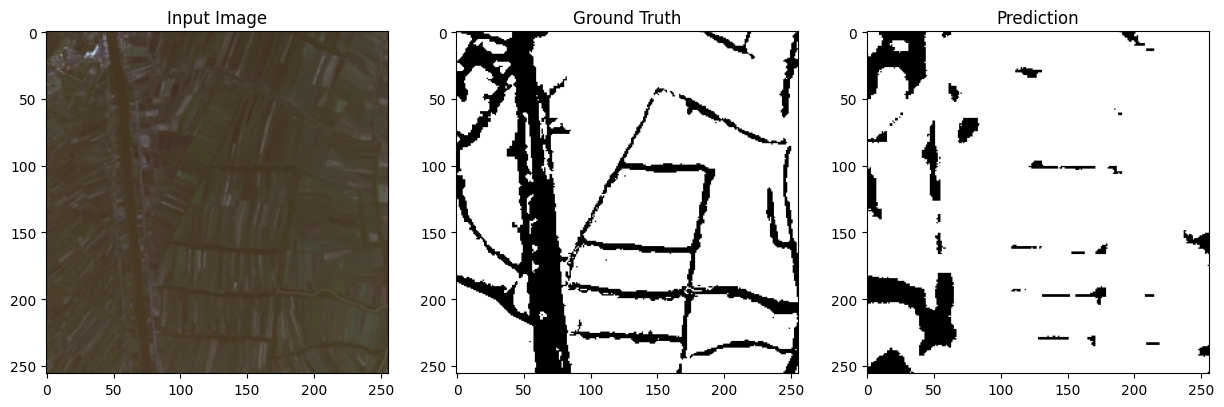

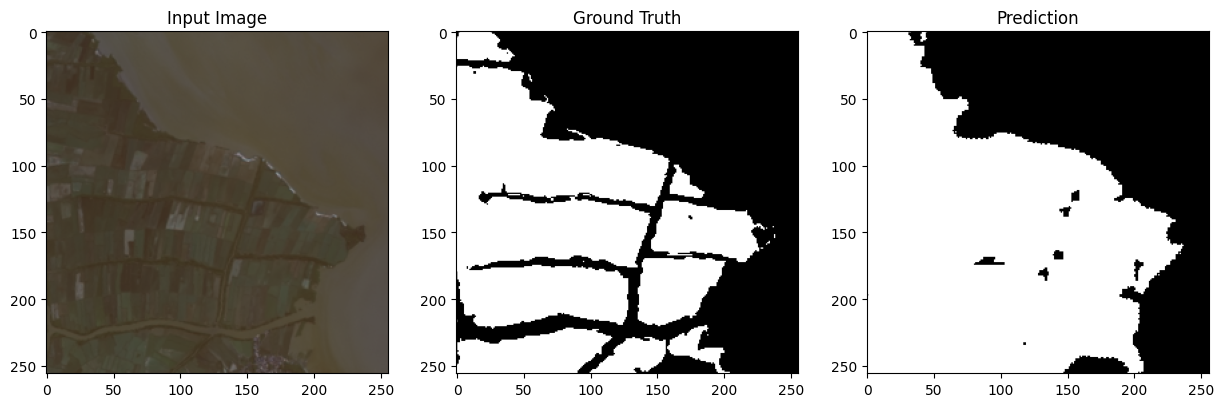

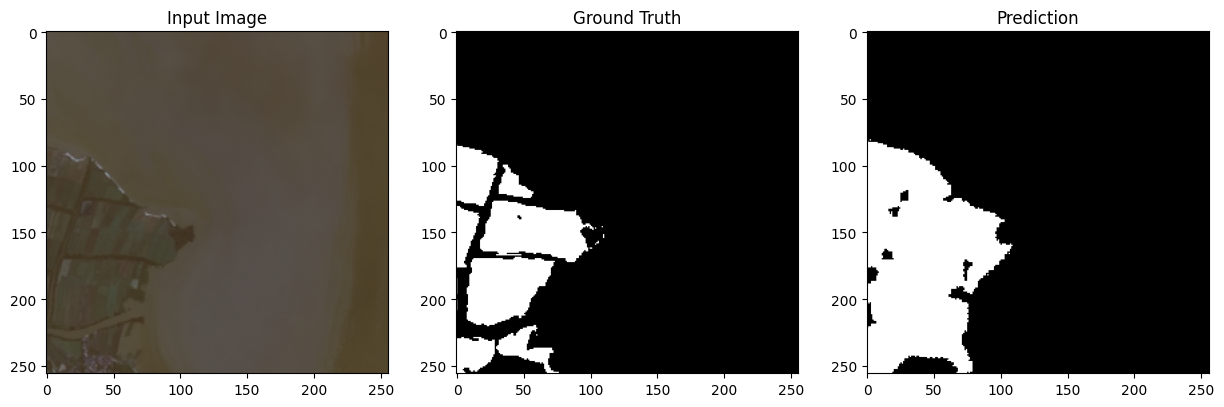

In [ ]:
# Visualize predictions
plot_predictions(model, val_loader, device, num_images=5)

## 8.2 Save trained model

In [ ]:

# Save the trained model's state dict
model_path = "/content/gdrive/My Drive/adleo_my/final_project/resunet_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")